<a href="https://colab.research.google.com/github/spros1/DistanceJoin/blob/main/DistanceJoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###First we need to install everything needed in order to run Python & Apache Spark in Colab


In [ ]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# download spark3.2.1
!wget -q https://ftp.cc.uoc.gr/mirrors/apache/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz 

In [ ]:
# unzip it
!tar xvf spark-3.2.1-bin-hadoop2.7.tgz

In [ ]:
# install findspark 
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

#### A test in order to check that all are ok

In [80]:
import findspark
findspark.init()                                               # make pyspark importable as a regular library
from pyspark.sql import SparkSession                           # create Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Test spark
df = spark.createDataFrame([{"hello": "world"} for x in range(1000)])
df.show(5)

+-----+
|hello|
+-----+
|world|
|world|
|world|
|world|
|world|
+-----+
only showing top 5 rows



# Now lets start :
For two sets given A and B ( with values (ID,X,Y) ) : <br>
Find the pairs (a,b), where a in Α and b in Β, 
to wich it applies : d(a,b) ≤ c, where c parameter given from the user 

### First we are going to make a routine in order to produce two csv files with the number of records that the user will give


In [81]:
# imports that are going to be used for the population for our two datasets 
import random
import time
import math
from random import sample
import csv
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

In [82]:
def get_generated_points( gen_num, csv_name):
  
  x = random.sample(range(1, gen_num+1), gen_num)
  y = random.sample(range(1, gen_num+1), gen_num)

  fin_data = list(zip(x,y))
 
# generate csv
  with open(csv_name, "a") as f:
    f.truncate(0)
    coords = [map(str, tupl) for tupl in fin_data]
    writer = csv.writer(f, delimiter=',')

    for line in coords:
      writer.writerow(line)

# plot it also that 
  plt.scatter(x, y)
  plt.show()

  return fin_data

#### Now the user must give the max number of points for the two datasets

In [83]:
inpCSV_total_points = 0
try:
  inpCSV_total_points = int(input("Enter the max value for csv with inp points : "))
except ValueError:
    print("This is not a number")   

Enter the max value for csv with inp points : 100


In [84]:
trainCSV_total_points = 0
try:
  trainCSV_total_points = int(input("Enter the max value for csv with train points : "))
except ValueError:
    print("This is not a number")   

Enter the max value for csv with train points : 80


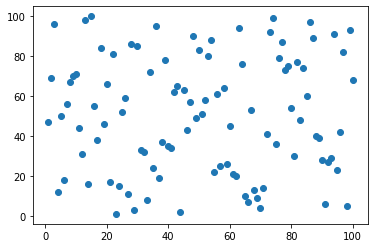

[(97, 82), (63, 94), (70, 4), (42, 62), (5, 50), (83, 48), (100, 68), (21, 17), (61, 21), (89, 39), (50, 83), (54, 88), (39, 78), (67, 53), (22, 81), (88, 40), (64, 76), (30, 85), (32, 32), (44, 2), (68, 13), (14, 16), (80, 54), (53, 80), (60, 45), (31, 33), (36, 95), (90, 28), (49, 49), (51, 51), (92, 27), (86, 97), (99, 93), (52, 58), (57, 25), (58, 64), (93, 29), (55, 22), (7, 56), (45, 63), (17, 38), (41, 34), (59, 26), (33, 8), (35, 24), (29, 3), (15, 100), (56, 61), (69, 9), (73, 92), (95, 23), (81, 30), (62, 20), (25, 52), (84, 74), (38, 37), (96, 42), (20, 66), (28, 86), (91, 6), (78, 73), (8, 67), (48, 90), (9, 70), (13, 98), (65, 10), (66, 7), (4, 12), (1, 47), (82, 77), (75, 36), (74, 99), (23, 1), (40, 35), (46, 43), (72, 41), (37, 19), (2, 69), (98, 5), (79, 75), (19, 46), (6, 18), (47, 57), (11, 44), (18, 84), (10, 71), (87, 89), (34, 72), (16, 55), (12, 31), (3, 96), (94, 91), (77, 87), (24, 15), (43, 65), (27, 11), (76, 79), (26, 59), (85, 60), (71, 14)]




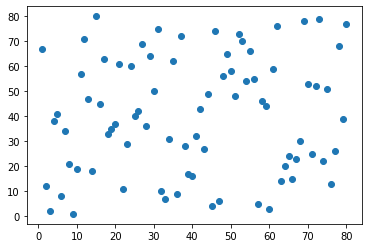

[(42, 43), (75, 51), (5, 41), (44, 49), (54, 54), (70, 53), (29, 64), (67, 23), (69, 78), (24, 60), (35, 62), (14, 18), (47, 6), (36, 9), (20, 37), (9, 1), (26, 42), (37, 72), (21, 61), (3, 2), (74, 22), (18, 33), (32, 10), (30, 50), (80, 77), (60, 3), (66, 15), (78, 68), (59, 44), (53, 70), (17, 63), (27, 69), (40, 16), (55, 66), (49, 65), (45, 4), (4, 38), (25, 40), (73, 79), (58, 46), (23, 29), (38, 28), (71, 25), (41, 32), (11, 57), (7, 34), (28, 36), (10, 19), (33, 7), (19, 35), (79, 39), (61, 59), (52, 73), (68, 30), (15, 80), (77, 26), (31, 75), (65, 24), (64, 20), (48, 56), (62, 76), (8, 21), (50, 58), (72, 52), (43, 27), (57, 5), (6, 8), (76, 13), (39, 17), (2, 12), (12, 71), (22, 11), (1, 67), (34, 31), (13, 47), (16, 45), (51, 48), (46, 74), (63, 14), (56, 55)]


In [85]:
# create the input dataset
inpPoints = get_generated_points(inpCSV_total_points , 'InputCSV.csv')
print(inpPoints)

print('\n')

trainPoints = get_generated_points(trainCSV_total_points , 'TrainCSV.csv')
print(trainPoints)

### Read from the two csvs the data
(from the two we create or other , it is the same just change the name of input file)


In [120]:
# importing the required module
from pyspark.sql           import SparkSession
from pyspark.sql           import functions as F
from pyspark.sql.functions import lit,col,concat, spark_partition_id, asc, desc
from pyspark.sql.types     import StringType, ArrayType
import os

In [87]:
# give the path of input and train file to read 
inpFile   = "InputCSV.csv" 
trainFile = "TrainCSV.csv"

In [88]:
# Initialize Spark session
t0 = int(round(time.time() * 1000))

In [89]:
spark = SparkSession.builder.appName("CSV").master("local").getOrCreate()             # Creates a session on a local master


In [90]:
t1 = int(round(time.time() * 1000))

print("Session initialized in {} ms".format(t1 - t0))

Session initialized in 2970 ms


In [91]:
df_inp   = spark.read.csv(inferSchema=True, path=inpFile).toDF("inpX"  ,"inpY"  )     # Reads input CSV file with no header, in a dataframe
df_train = spark.read.csv(inferSchema=True, path=trainFile).toDF("trainX","trainY")   # Reads train CSV file with no header, in a dataframe

In [92]:
t2 = int(round(time.time() * 1000))
print("Initial dataframe built in {} ms".format(t2 - t1))

Initial dataframe built in 2733 ms


In [93]:
print("*** Right after ingestion ***")

df_inp.show(5)
print("We have {} input records.".format(df_inp.count()))

print('\n')

df_train.show(5)
print("We have {} train records.".format(df_train.count()))

*** Right after ingestion ***
+----+----+
|inpX|inpY|
+----+----+
|  97|  82|
|  63|  94|
|  70|   4|
|  42|  62|
|   5|  50|
+----+----+
only showing top 5 rows

We have 100 input records.


+------+------+
|trainX|trainY|
+------+------+
|    42|    43|
|    75|    51|
|     5|    41|
|    44|    49|
|    54|    54|
+------+------+
only showing top 5 rows

We have 80 train records.


In [94]:
# Print the schema to standard output (stdout) by using printSchema().
df_inp.printSchema()
df_train.printSchema()

root
 |-- inpX: integer (nullable = true)
 |-- inpY: integer (nullable = true)

root
 |-- trainX: integer (nullable = true)
 |-- trainY: integer (nullable = true)



### Find min & max x y for both datasets, and for total (limits of grid)


In [95]:
def dfMaxMin(dtf,columnNamex,columnNamey ): 

  dtf_X_Min = dtf.agg({columnNamex: 'min'}).collect()[0][0]
  dtf_X_Max = dtf.agg({columnNamex: 'max'}).collect()[0][0]
  dtf_Y_Min = dtf.agg({columnNamey: 'min'}).collect()[0][0]
  dtf_Y_Max = dtf.agg({columnNamey: 'max'}).collect()[0][0]

  return dtf_X_Min, dtf_X_Max, dtf_Y_Min, dtf_Y_Max

In [96]:
# call function to find min max per dataframe
minX_inp,maxX_inp,minY_inp,maxY_inp = dfMaxMin(df_inp, 'inpX', 'inpY')
print( minX_inp,maxX_inp, '-', minY_inp,maxY_inp )

minX_trn,maxX_trn, minY_trn,maxY_trn  = dfMaxMin(df_train, 'trainX', 'trainY')
print( minX_trn,maxX_trn, '-', minY_trn,maxY_trn )

1 100 - 1 100
1 80 - 1 80


In [97]:
# last find totam min max 
min_quadranX = (min(minX_inp,minX_trn))
max_quadranX = (max(maxX_inp,maxX_trn))

min_quadranY = (max(minY_inp,minY_trn))
max_quadranY = (max(maxY_inp,maxY_trn))

print(min_quadranX, max_quadranX, '-', min_quadranY, max_quadranY )


1 100 - 1 100


### Plot the points ( inp -> o , train -> x )

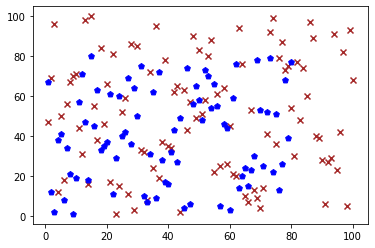

In [98]:
mx = [val.inpX for val in df_inp.select('inpX').collect()]
my = [val.inpY for val in df_inp.select('inpY').collect()]
plt.scatter(mx, my, marker='x', color = 'brown')

tx = [val.trainX for val in df_train.select('trainX').collect()]
ty = [val.trainY for val in df_train.select('trainY').collect()]
plt.scatter(tx, ty, marker='p', color = 'blue')

plt.show()

Get the value for distance range from user

In [99]:
range_val = 0
try:
  range_val = float(input("Enter the value for distance between the points: "))
except ValueError:
    print("This is not a number")    

Enter the value for distance between the points: 1


### We are going to find the size for the cells that the grid will split

In [100]:
total_splits = 0
try:
  total_splits = int(input("Enter the value for splits: "))
except ValueError:
    print("This is not a number")  

Enter the value for splits: 20


In [101]:
dimension_x = abs((max_quadranX - min_quadranX)) / total_splits
dimension_y = abs((max_quadranY - min_quadranY)) / total_splits

print(dimension_x, dimension_y)

4.95 4.95


#### As the next step we will generate two more dataframes same as the previous with the addition of a column that will hold the value of the cellid that the point x,y belongs to, and also one final dataframe with the addition of a column holding the neighbors


In [102]:
# we are going to use struct function in order to produce the new column.
df_inp_splitted = df_inp.withColumn("cid",
                                F.struct( ( (df_inp['inpX']  - min_quadranX) / dimension_x).cast("Integer"),
                                          ( (df_inp['inpY']  - min_quadranY) / dimension_y).cast("Integer") ) 
                                )

df_inp_splitted.show()


df_train_splitted = df_train.withColumn("cid",
                                F.struct( ( (df_train['trainX']  - min_quadranX) / dimension_x).cast("Integer"),
                                          ( (df_train['trainY']  - min_quadranY) / dimension_y).cast("Integer") ) 
                                )

df_train_splitted.show()

+----+----+--------+
|inpX|inpY|     cid|
+----+----+--------+
|  97|  82|{19, 16}|
|  63|  94|{12, 18}|
|  70|   4| {13, 0}|
|  42|  62| {8, 12}|
|   5|  50|  {0, 9}|
|  83|  48| {16, 9}|
| 100|  68|{20, 13}|
|  21|  17|  {4, 3}|
|  61|  21| {12, 4}|
|  89|  39| {17, 7}|
|  50|  83| {9, 16}|
|  54|  88|{10, 17}|
|  39|  78| {7, 15}|
|  67|  53|{13, 10}|
|  22|  81| {4, 16}|
|  88|  40| {17, 7}|
|  64|  76|{12, 15}|
|  30|  85| {5, 16}|
|  32|  32|  {6, 6}|
|  44|   2|  {8, 0}|
+----+----+--------+
only showing top 20 rows

+------+------+--------+
|trainX|trainY|     cid|
+------+------+--------+
|    42|    43|  {8, 8}|
|    75|    51|{14, 10}|
|     5|    41|  {0, 8}|
|    44|    49|  {8, 9}|
|    54|    54|{10, 10}|
|    70|    53|{13, 10}|
|    29|    64| {5, 12}|
|    67|    23| {13, 4}|
|    69|    78|{13, 15}|
|    24|    60| {4, 11}|
|    35|    62| {6, 12}|
|    14|    18|  {2, 3}|
|    47|     6|  {9, 1}|
|    36|     9|  {7, 1}|
|    20|    37|  {3, 7}|
|     9|     1|  {1,

#### As the cell_id's created for each point at both dataframes we can proceed to find the given cell_id for the Neighbors points


##### First the creation of functions that are going to be used 

In [103]:
## function in order to find the points that are close
def find_close_points(cid):

  # initialize parameters
    X            = total_splits-1
    Y            = total_splits-1
    c_x          = cid[0]
    c_y          = cid[1]
    closePoints  = []

  # start the loops in order to characterize the relationship between the points 
    for x2 in range(c_x-1, c_x+2):
        for y2 in range(c_y-1, c_y+2):

           if (    ( 0 <= c_x <= X )
               and ( 0 <= c_y <= Y ) 
               and ( 0 <= x2  <= X ) 
               and ( 0 <= y2  <= Y )
               and (    c_x  != x2
                     or c_y  != y2)  ):
             
             # T -> Top
             # B -> Bottom
                if x2 == c_x:
                  if y2 > c_y:
                    pos = 'T'
                  else:
                    pos = 'B'

             # R -> Right 
             # L -> Left
                if y2 == c_y:
                  if x2 > c_x:
                    pos = 'R'
                  else: 
                    pos = 'L'

             # TR -> Top right
             # BR -> Bottom right
                if x2 > c_x:
                  if y2 > c_y:
                    pos = 'TR'
                  elif y2 < c_y:
                    pos = 'BR'

             # TL -> Top left
             # BL -> Bottom left
                if x2 < c_x:
                  if y2 > c_y:
                    pos = 'TL'
                  elif y2 < c_y:
                    pos = 'BL' 
                
                closePoints.append((x2, y2, pos))
                
    return closePoints

In [104]:
# UDF declares that this is a user defined function
find_neighbors_udf = F.udf(find_close_points, ArrayType(ArrayType(StringType())))

In [105]:
## create new dataframe that holds also the relationship between neighbors
df_inp_splitted_with_rela = df_inp_splitted.withColumn('Nghbr', find_neighbors_udf(df_inp_splitted['cid']))

df_inp_splitted_with_rela.show()

+----+----+--------+--------------------+
|inpX|inpY|     cid|               Nghbr|
+----+----+--------+--------------------+
|  97|  82|{19, 16}|[[18, 15, BL], [1...|
|  63|  94|{12, 18}|[[11, 17, BL], [1...|
|  70|   4| {13, 0}|[[12, 0, L], [12,...|
|  42|  62| {8, 12}|[[7, 11, BL], [7,...|
|   5|  50|  {0, 9}|[[0, 8, B], [0, 1...|
|  83|  48| {16, 9}|[[15, 8, BL], [15...|
| 100|  68|{20, 13}|                  []|
|  21|  17|  {4, 3}|[[3, 2, BL], [3, ...|
|  61|  21| {12, 4}|[[11, 3, BL], [11...|
|  89|  39| {17, 7}|[[16, 6, BL], [16...|
|  50|  83| {9, 16}|[[8, 15, BL], [8,...|
|  54|  88|{10, 17}|[[9, 16, BL], [9,...|
|  39|  78| {7, 15}|[[6, 14, BL], [6,...|
|  67|  53|{13, 10}|[[12, 9, BL], [12...|
|  22|  81| {4, 16}|[[3, 15, BL], [3,...|
|  88|  40| {17, 7}|[[16, 6, BL], [16...|
|  64|  76|{12, 15}|[[11, 14, BL], [1...|
|  30|  85| {5, 16}|[[4, 15, BL], [4,...|
|  32|  32|  {6, 6}|[[5, 5, BL], [5, ...|
|  44|   2|  {8, 0}|[[7, 0, L], [7, 1...|
+----+----+--------+--------------

In [106]:
## Function "extendpoints" makes copy of points that are close enough with neighbor cells
def extendpoints(data):

   # initialize parameters
    min_x       = float(data[0])
    max_x       = float(data[1])
    min_y       = float(data[2])
    max_y       = float(data[3])
    dimension_x = float(data[4])
    dimension_y = float(data[5])
    cell_id     = data[6]
    nei         = data[7]
    x           = float(data[8])
    y           = float(data[9])
    r           = float(data[10])
    cell_x      = cell_id[0]
    cell_y      = cell_id[1]

    # Calculate current cell bounds
    bound_u_y = min_y + ((cell_y+1) * dimension_y)
    bound_d_y = min_y + ((cell_y)   * dimension_y)
    bound_r_x = min_x + ((cell_x+1) * dimension_x)
    bound_l_x = min_x + ((cell_x)   * dimension_x)

    dupl_to = [(cell_x, cell_y)]

    # For each neighbor point 
    for n in nei:
        print(n)
        print(n[2])
        n_idx = int(n[0])
        n_idy = int(n[1])
        n_pos = n[2]


        if ( n_pos == 'T' ) and ( y + r > bound_u_y ) :
                dupl_to.append((n_idx, n_idy))
        elif ( n_pos == 'TR' ) and (sqrt((bound_r_x-x)**2 + (bound_u_y-y)**2) < r) :
                dupl_to.append((n_idx, n_idy))
        elif ( n_pos == 'R' ) and ( x + r > bound_r_x ) :
                dupl_to.append((n_idx, n_idy))
        elif ( n_pos == 'BR' ) and (sqrt((bound_r_x-x)**2 + (bound_d_y-y)**2) < r) :
                dupl_to.append((n_idx, n_idy))
        elif ( n_pos == 'B' ) and ( y - r < bound_d_y) :
                dupl_to.append((n_idx, n_idy))
        elif ( n_pos == 'BL' ) and (sqrt((bound_l_x-x)**2 + (bound_d_y-y)**2) < r) :
                dupl_to.append((n_idx, n_idy))
        elif ( n_pos == 'L' ) and ( x - r < bound_l_x) :
                dupl_to.append((n_idx, n_idy))
        elif ( n_pos == 'TL' ) and (sqrt((bound_l_x-x)**2 + (bound_u_y-y)**2) < r) :
                dupl_to.append((n_idx, n_idy))

    return tuple(dupl_to)


In [107]:
# declare as udf function
extendpoints_to_udf = F.udf(extendpoints, ArrayType(ArrayType(StringType())))

In [108]:
#Create new DataFrame with new column with close points
df_inp_splitted_with_rela_and_dupl = df_inp_splitted_with_rela.withColumn('dupl',
                                                      F.explode(extendpoints_to_udf(F.struct(F.lit(min_quadranX)                   ,
                                                                                             F.lit(max_quadranX)                   ,
                                                                                             F.lit(min_quadranY)                   ,
                                                                                             F.lit(max_quadranY)                   ,
                                                                                             F.lit(dimension_x)                    ,
                                                                                             F.lit(dimension_y)                    ,
                                                                                             df_inp_splitted_with_rela["cid"]      ,
                                                                                             df_inp_splitted_with_rela["Nghbr"]    ,
                                                                                             df_inp_splitted_with_rela["inpX"]     , 
                                                                                             df_inp_splitted_with_rela["inpY"]     ,
                                                                                             F.lit(range_val)
                                                                                             )
                                                                                     )
                                                              )
                                                      )
df_inp_splitted_with_rela_and_dupl.show()
df_inp_splitted_with_rela_and_dupl.count()

+----+----+--------+--------------------+--------+
|inpX|inpY|     cid|               Nghbr|    dupl|
+----+----+--------+--------------------+--------+
|  97|  82|{19, 16}|[[18, 15, BL], [1...|[19, 16]|
|  63|  94|{12, 18}|[[11, 17, BL], [1...|[12, 18]|
|  70|   4| {13, 0}|[[12, 0, L], [12,...| [13, 0]|
|  70|   4| {13, 0}|[[12, 0, L], [12,...| [14, 0]|
|  42|  62| {8, 12}|[[7, 11, BL], [7,...| [8, 12]|
|   5|  50|  {0, 9}|[[0, 8, B], [0, 1...|  [0, 9]|
|   5|  50|  {0, 9}|[[0, 8, B], [0, 1...| [0, 10]|
|   5|  50|  {0, 9}|[[0, 8, B], [0, 1...|  [1, 9]|
|  83|  48| {16, 9}|[[15, 8, BL], [15...| [16, 9]|
| 100|  68|{20, 13}|                  []|[20, 13]|
|  21|  17|  {4, 3}|[[3, 2, BL], [3, ...|  [4, 3]|
|  21|  17|  {4, 3}|[[3, 2, BL], [3, ...|  [3, 3]|
|  61|  21| {12, 4}|[[11, 3, BL], [11...| [12, 4]|
|  61|  21| {12, 4}|[[11, 3, BL], [11...| [11, 3]|
|  61|  21| {12, 4}|[[11, 3, BL], [11...| [11, 4]|
|  61|  21| {12, 4}|[[11, 3, BL], [11...| [12, 3]|
|  89|  39| {17, 7}|[[16, 6, BL

187

 Replace the local temporary views

In [109]:
df_inp_splitted.createOrReplaceTempView("df_inp_splitted")
df_train_splitted.createOrReplaceTempView("df_train_splitted")

Count the number of points that each cell_id has 

In [110]:
# groupby each cell_id and count (for df_inp after duplication)
df_inp_cid_cnt = df_inp_splitted_with_rela_and_dupl.groupBy("dupl").count()
df_inp_cid_cnt.show()

# groupby each cell_id and count (for df_train after duplication)
df_train_cid_cnt = df_train_splitted.groupBy("cid").count()
df_train_cid_cnt.show()

+--------+-----+
|    dupl|count|
+--------+-----+
| [5, 10]|    1|
|[10, 16]|    2|
|[15, 15]|    2|
| [17, 7]|    2|
|  [4, 2]|    1|
|[16, 14]|    1|
| [3, 10]|    1|
|[19, 16]|    1|
|  [3, 8]|    1|
|[18, 18]|    1|
| [1, 11]|    1|
| [19, 8]|    1|
|[15, 17]|    1|
|  [5, 1]|    1|
|[17, 17]|    1|
|  [2, 8]|    1|
| [0, 19]|    1|
|  [2, 3]|    1|
| [3, 12]|    1|
|[10, 12]|    1|
+--------+-----+
only showing top 20 rows

+--------+-----+
|     cid|count|
+--------+-----+
|{13, 10}|    1|
|  {1, 0}|    1|
|  {6, 1}|    2|
|{15, 15}|    1|
|  {8, 9}|    1|
| {0, 13}|    1|
| {7, 14}|    1|
| {11, 8}|    1|
|  {2, 3}|    1|
|  {7, 1}|    1|
|  {4, 7}|    1|
| {12, 2}|    1|
|  {0, 7}|    1|
|  {9, 1}|    1|
|{13, 15}|    1|
|{10, 13}|    2|
|{14, 15}|    1|
|  {5, 7}|    1|
| {15, 5}|    1|
| {4, 11}|    1|
+--------+-----+
only showing top 20 rows



Create DataFrame with each point and the cell_id that is contained (about df_inp)

In [111]:
df_inp_total = df_inp_splitted_with_rela_and_dupl.drop('cid', 'Nghbr')
final_df_inp = df_inp_total.withColumnRenamed("dupl","cid").withColumn("Dataset", F.lit("df_inp"))

final_df_inp.printSchema()
final_df_inp.show()

root
 |-- inpX: integer (nullable = true)
 |-- inpY: integer (nullable = true)
 |-- cid: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Dataset: string (nullable = false)

+----+----+--------+-------+
|inpX|inpY|     cid|Dataset|
+----+----+--------+-------+
|  97|  82|[19, 16]| df_inp|
|  63|  94|[12, 18]| df_inp|
|  70|   4| [13, 0]| df_inp|
|  70|   4| [14, 0]| df_inp|
|  42|  62| [8, 12]| df_inp|
|   5|  50|  [0, 9]| df_inp|
|   5|  50| [0, 10]| df_inp|
|   5|  50|  [1, 9]| df_inp|
|  83|  48| [16, 9]| df_inp|
| 100|  68|[20, 13]| df_inp|
|  21|  17|  [4, 3]| df_inp|
|  21|  17|  [3, 3]| df_inp|
|  61|  21| [12, 4]| df_inp|
|  61|  21| [11, 3]| df_inp|
|  61|  21| [11, 4]| df_inp|
|  61|  21| [12, 3]| df_inp|
|  89|  39| [17, 7]| df_inp|
|  50|  83| [9, 16]| df_inp|
|  50|  83|[10, 16]| df_inp|
|  54|  88|[10, 17]| df_inp|
+----+----+--------+-------+
only showing top 20 rows



Create DataFrame with each point and the cell_id that is contained (about df_train)

In [112]:
df_train_splitted = df_train_splitted.withColumn("Dataset", F.lit("df_train"))

df_train_splitted.printSchema()
df_train_splitted.show()

root
 |-- trainX: integer (nullable = true)
 |-- trainY: integer (nullable = true)
 |-- cid: struct (nullable = false)
 |    |-- col1: integer (nullable = true)
 |    |-- col2: integer (nullable = true)
 |-- Dataset: string (nullable = false)

+------+------+--------+--------+
|trainX|trainY|     cid| Dataset|
+------+------+--------+--------+
|    42|    43|  {8, 8}|df_train|
|    75|    51|{14, 10}|df_train|
|     5|    41|  {0, 8}|df_train|
|    44|    49|  {8, 9}|df_train|
|    54|    54|{10, 10}|df_train|
|    70|    53|{13, 10}|df_train|
|    29|    64| {5, 12}|df_train|
|    67|    23| {13, 4}|df_train|
|    69|    78|{13, 15}|df_train|
|    24|    60| {4, 11}|df_train|
|    35|    62| {6, 12}|df_train|
|    14|    18|  {2, 3}|df_train|
|    47|     6|  {9, 1}|df_train|
|    36|     9|  {7, 1}|df_train|
|    20|    37|  {3, 7}|df_train|
|     9|     1|  {1, 0}|df_train|
|    26|    42|  {5, 8}|df_train|
|    37|    72| {7, 14}|df_train|
|    21|    61| {4, 12}|df_train|
|     3|

In [113]:
# also change cid data type to array for train dataframe
df_train_splitted = df_train_splitted.withColumn("cid", F.array(df_train_splitted["cid"].getField("col1"), df_train_splitted["cid"].getField("col2")))
df_train_splitted.show()

+------+------+--------+--------+
|trainX|trainY|     cid| Dataset|
+------+------+--------+--------+
|    42|    43|  [8, 8]|df_train|
|    75|    51|[14, 10]|df_train|
|     5|    41|  [0, 8]|df_train|
|    44|    49|  [8, 9]|df_train|
|    54|    54|[10, 10]|df_train|
|    70|    53|[13, 10]|df_train|
|    29|    64| [5, 12]|df_train|
|    67|    23| [13, 4]|df_train|
|    69|    78|[13, 15]|df_train|
|    24|    60| [4, 11]|df_train|
|    35|    62| [6, 12]|df_train|
|    14|    18|  [2, 3]|df_train|
|    47|     6|  [9, 1]|df_train|
|    36|     9|  [7, 1]|df_train|
|    20|    37|  [3, 7]|df_train|
|     9|     1|  [1, 0]|df_train|
|    26|    42|  [5, 8]|df_train|
|    37|    72| [7, 14]|df_train|
|    21|    61| [4, 12]|df_train|
|     3|     2|  [0, 0]|df_train|
+------+------+--------+--------+
only showing top 20 rows



Last create one dataframe with the combined data from the two datasets

In [115]:
df_combined_with_cells = final_df_inp.union(df_train_splitted)
df_combined_with_cells.show(truncate=False)

+----+----+--------+-------+
|inpX|inpY|cid     |Dataset|
+----+----+--------+-------+
|97  |82  |[19, 16]|df_inp |
|63  |94  |[12, 18]|df_inp |
|70  |4   |[13, 0] |df_inp |
|70  |4   |[14, 0] |df_inp |
|42  |62  |[8, 12] |df_inp |
|5   |50  |[0, 9]  |df_inp |
|5   |50  |[0, 10] |df_inp |
|5   |50  |[1, 9]  |df_inp |
|83  |48  |[16, 9] |df_inp |
|100 |68  |[20, 13]|df_inp |
|21  |17  |[4, 3]  |df_inp |
|21  |17  |[3, 3]  |df_inp |
|61  |21  |[12, 4] |df_inp |
|61  |21  |[11, 3] |df_inp |
|61  |21  |[11, 4] |df_inp |
|61  |21  |[12, 3] |df_inp |
|89  |39  |[17, 7] |df_inp |
|50  |83  |[9, 16] |df_inp |
|50  |83  |[10, 16]|df_inp |
|54  |88  |[10, 17]|df_inp |
+----+----+--------+-------+
only showing top 20 rows



Count the number of points that each cell_id has

In [118]:
df_combined_cells_cnt = df_combined_with_cells.groupBy("cid").count().orderBy("count", ascending=True)

df_combined_cells_cnt.show()
df_combined_cells_cnt.count()

+--------+-----+
|     cid|count|
+--------+-----+
| [9, 10]|    1|
| [14, 0]|    1|
|  [5, 2]|    1|
| [7, 15]|    1|
| [3, 10]|    1|
| [12, 9]|    1|
|[18, 18]|    1|
|[16, 19]|    1|
| [19, 8]|    1|
| [4, 16]|    1|
|  [5, 1]|    1|
|[15, 10]|    1|
|  [2, 8]|    1|
|  [3, 3]|    1|
|[10, 12]|    1|
| [16, 5]|    1|
| [5, 10]|    1|
| [19, 4]|    1|
|[19, 16]|    1|
| [6, 17]|    1|
+--------+-----+
only showing top 20 rows



191

Partition all the points into 16 Partitions with the statement that the points with a specific "cell_id" are in the same partition

In [121]:
df_partitioned = df_combined_with_cells.repartition(1, 'cid')
df_partitioned.show()

+----+----+--------+-------+
|inpX|inpY|     cid|Dataset|
+----+----+--------+-------+
|  97|  82|[19, 16]| df_inp|
|  63|  94|[12, 18]| df_inp|
|  70|   4| [13, 0]| df_inp|
|  70|   4| [14, 0]| df_inp|
|  42|  62| [8, 12]| df_inp|
|   5|  50|  [0, 9]| df_inp|
|   5|  50| [0, 10]| df_inp|
|   5|  50|  [1, 9]| df_inp|
|  83|  48| [16, 9]| df_inp|
| 100|  68|[20, 13]| df_inp|
|  21|  17|  [4, 3]| df_inp|
|  21|  17|  [3, 3]| df_inp|
|  61|  21| [12, 4]| df_inp|
|  61|  21| [11, 3]| df_inp|
|  61|  21| [11, 4]| df_inp|
|  61|  21| [12, 3]| df_inp|
|  89|  39| [17, 7]| df_inp|
|  50|  83| [9, 16]| df_inp|
|  50|  83|[10, 16]| df_inp|
|  54|  88|[10, 17]| df_inp|
+----+----+--------+-------+
only showing top 20 rows



In [122]:
df_partitioned.count()
df_partitioned.rdd.getNumPartitions()

1

In [123]:
df_partitioned\
    .withColumn("partitionId", spark_partition_id())\
    .groupBy("partitionId")\
    .count()\
    .orderBy(asc("count"))\
    .show()

+-----------+-----+
|partitionId|count|
+-----------+-----+
|          0|  267|
+-----------+-----+



In [125]:
df_partitioned.show()

+----+----+--------+-------+
|inpX|inpY|     cid|Dataset|
+----+----+--------+-------+
|  97|  82|[19, 16]| df_inp|
|  63|  94|[12, 18]| df_inp|
|  70|   4| [13, 0]| df_inp|
|  70|   4| [14, 0]| df_inp|
|  42|  62| [8, 12]| df_inp|
|   5|  50|  [0, 9]| df_inp|
|   5|  50| [0, 10]| df_inp|
|   5|  50|  [1, 9]| df_inp|
|  83|  48| [16, 9]| df_inp|
| 100|  68|[20, 13]| df_inp|
|  21|  17|  [4, 3]| df_inp|
|  21|  17|  [3, 3]| df_inp|
|  61|  21| [12, 4]| df_inp|
|  61|  21| [11, 3]| df_inp|
|  61|  21| [11, 4]| df_inp|
|  61|  21| [12, 3]| df_inp|
|  89|  39| [17, 7]| df_inp|
|  50|  83| [9, 16]| df_inp|
|  50|  83|[10, 16]| df_inp|
|  54|  88|[10, 17]| df_inp|
+----+----+--------+-------+
only showing top 20 rows



####Query
#### Join each point of df_inp with the points of df_train that are in the same cell

In [139]:
# keep the time that query is about to start 
t4 = int(round(time.time() * 1000))

In [140]:
# Join every point of df_inp and df_train that are in the same cell
df_partitioned_joined = df_partitioned.filter(df_partitioned['dataset'] == 'df_inp').select(
                                                                                                       df_partitioned["inpY"].alias("df_inp_Y"),
                                                                                                       df_partitioned["inpX"].alias("df_inp_X"),
                                                                                                       df_partitioned["cid"])\
                             .join(df_partitioned.filter(df_partitioned['dataset'] == 'df_train').select(
                                                                                                       df_partitioned["inpY"].alias("df_train_Y"),
                                                                                                       df_partitioned["inpX"].alias("df_train_X"),
                                                                                                       df_partitioned["cid"]),
                                                                                                       ['cid'])
df_partitioned_joined.show()

+--------+--------+--------+----------+----------+
|     cid|df_inp_Y|df_inp_X|df_train_Y|df_train_X|
+--------+--------+--------+----------+----------+
| [12, 4]|      21|      61|        24|        65|
| [12, 3]|      21|      61|        20|        64|
|[13, 10]|      53|      67|        53|        70|
|[12, 15]|      76|      64|        76|        62|
|  [6, 6]|      32|      32|        31|        34|
|  [8, 0]|       2|      44|         4|        45|
| [13, 2]|      13|      68|        15|        66|
|  [2, 3]|      16|      14|        18|        14|
| [11, 8]|      45|      60|        44|        59|
| [11, 9]|      45|      60|        46|        58|
|  [6, 6]|      33|      31|        31|        34|
|[10, 10]|      51|      51|        54|        54|
| [10, 9]|      51|      51|        48|        51|
| [9, 12]|      63|      45|        65|        49|
|  [3, 7]|      38|      17|        37|        20|
|  [8, 6]|      34|      41|        32|        41|
|  [6, 1]|       8|      33|   

In [145]:
t5 = int(round(time.time() * 1000))
print("Query run at {} ms".format(t5 - t4))

Query run at 50045 ms


#### Calculate the distance for each pair of points

In [146]:
# keep the time that calculation of distance is about to start 
t6 = int(round(time.time() * 1000))

In [147]:
#calculate distance between points using Pythagoras' theorem
df_partitioned_joined_with_dist = df_partitioned_joined.withColumn("dist", F.sqrt((df_partitioned_joined['df_inp_y']-df_partitioned_joined['df_train_y'])** 2 + (df_partitioned_joined['df_inp_x']-df_partitioned_joined['df_train_x'])** 2))

df_partitioned_joined_with_dist.show(50)
df_partitioned_joined_with_dist.count()

+--------+--------+--------+----------+----------+------------------+
|     cid|df_inp_Y|df_inp_X|df_train_Y|df_train_X|              dist|
+--------+--------+--------+----------+----------+------------------+
| [12, 4]|      21|      61|        24|        65|               5.0|
| [12, 3]|      21|      61|        20|        64|3.1622776601683795|
|[13, 10]|      53|      67|        53|        70|               3.0|
|[12, 15]|      76|      64|        76|        62|               2.0|
|  [6, 6]|      32|      32|        31|        34|  2.23606797749979|
|  [8, 0]|       2|      44|         4|        45|  2.23606797749979|
| [13, 2]|      13|      68|        15|        66|2.8284271247461903|
|  [2, 3]|      16|      14|        18|        14|               2.0|
| [11, 8]|      45|      60|        44|        59|1.4142135623730951|
| [11, 9]|      45|      60|        46|        58|  2.23606797749979|
|  [6, 6]|      33|      31|        31|        34| 3.605551275463989|
|[10, 10]|      51| 

44

In [148]:
t7 = int(round(time.time() * 1000))
print("Calculation for distance run at {} ms".format(t7 - t6))

Calculation for distance run at 36941 ms


##Final create a Df to keep only the points that satisfy the distance given

In [149]:
reduced_df = df_partitioned_joined_with_dist.filter(F.col("dist") <= range_val)
reduced_df.show()

+------+--------+--------+----------+----------+----+
|   cid|df_inp_Y|df_inp_X|df_train_Y|df_train_X|dist|
+------+--------+--------+----------+----------+----+
|[6, 1]|       8|      33|         7|        33| 1.0|
+------+--------+--------+----------+----------+----+



In [150]:
reduced_df.count()

1

In [151]:
# the previous were just to test that spark was ok set up
spark.stop()